In [1]:
import sys
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
sys.path.append("/home/panhailin/software/git/spateo-release/") # If you have installed spateo, comment out this line of code.
import spateo as st

/home/panhailin/software/executable/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/panhailin/software/executable/miniconda3/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# Load long matrix file and use intronic UMI to segment cells

In [17]:
total, exonic, intronic, x_min, y_min = st.io.read_bgi_agg('long_matrix.xrange_3059-13566_yrange_6158-19802.matrix')
total, exonic, intronic = total.T, exonic.T, intronic.T

Text(0.5, 1.0, 'intronic')

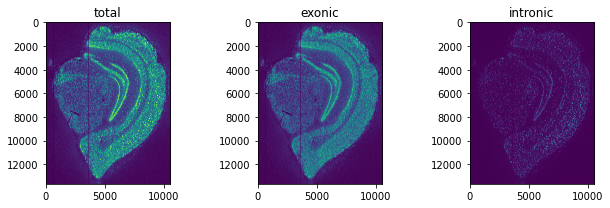

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(total.A, vmin=0, vmax=5)
axes[0].set_title('total')
axes[1].imshow(exonic.A, vmin=0, vmax=5)
axes[1].set_title('exonic')
axes[2].imshow(intronic.A, vmin=0, vmax=5)
axes[2].set_title('intronic')

In [30]:
rna_scores = st.pp.segmentation.icell.score_pixels(
    intronic,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3)
)

Text(0.5, 1.0, 'cell segmentation')

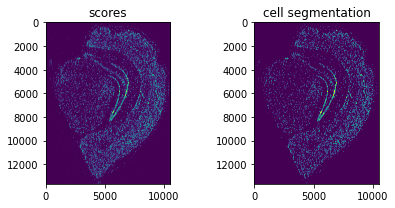

In [43]:
rna_thresholds = skimage.filters.threshold_multiotsu(rna_scores, classes=3)
# Kernel size of the morphological close and open operations (k=7 here) needs to be changed according to real data.
rna_cell_mask = st.pp.segmentation.utils.apply_threshold(rna_scores, k=7, threshold=rna_thresholds[1])
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(rna_scores)
axes[0].set_title('scores')
axes[1].imshow(rna_cell_mask)
axes[1].set_title('cell segmentation')

In [44]:
# Kernel size of the gauss convolution (k=21 here) needs to be changed according to real data.
rna_blur = st.pp.segmentation.label.utils.conv2d(rna_scores, k=21, mode="gauss")

coordinates = peak_local_max(rna_blur, min_distance=11)
rna_makers = np.zeros_like(rna_blur, dtype=np.int8)
rna_makers[tuple(coordinates.T)] = 1
rna_makers = rna_makers.astype(bool)
rna_cell_labels = st.pp.segmentation.label.watershed(total, rna_cell_mask, rna_makers, 21)
# distance and max_area need to be changed. est_density_enlarged is a ndarray indicates cell labels, pixels within one cell 
# have the same values.
rna_cell_labels_enlarged = st.pp.segmentation.label.expand_labels(rna_cell_labels, distance=5, max_area=400)

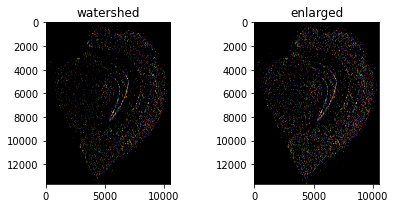

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(rna_cell_labels))
axes[0].set_title('watershed')
axes[1].imshow(skimage.color.label2rgb(rna_cell_labels_enlarged))
axes[1].set_title('enlarged')
np.save("rna_cell_labels.npy", rna_cell_labels_enlarged)
#Using 'rna_cell_labels_enlarged = np.load("rna_cell_labels.npy")'  to read in cell labels for following steps.

# Load ssDNA figure and used for cell segmentation

Text(0.5, 1.0, 'ssDNA')

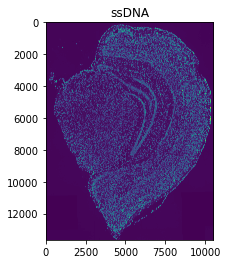

In [8]:
ssDNA = cv2.imread('ssDNA.xrange_3059-13566_yrange_6158-19802.tif',0)
plt.imshow(ssDNA)
plt.title("ssDNA")

In [9]:
ssDNA_scores = st.pp.segmentation.icell.score_pixels(
    ssDNA,
    k=5,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=2 / 3, q=1 / 3)
)

Text(0.5, 1.0, 'cell segmentation')

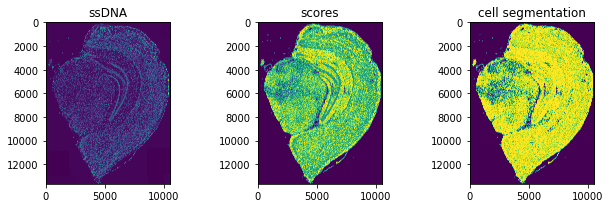

In [10]:
ssDNA_thresholds = skimage.filters.threshold_multiotsu(ssDNA_scores, classes=3)
ssDNA_cell_mask = st.pp.segmentation.utils.apply_threshold(ssDNA_scores, 7, ssDNA_thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(ssDNA)
axes[0].set_title('ssDNA')
axes[1].imshow(ssDNA_scores)
axes[1].set_title('scores')
axes[2].imshow(ssDNA_cell_mask)
axes[2].set_title('cell segmentation')

In [11]:
# Kernel size of the gauss convolution (k=21 here) needs to be changed according to real data.
ssDNA_blur = st.pp.segmentation.label.utils.conv2d(ssDNA_scores, k=21, mode="gauss")
coordinates = peak_local_max(ssDNA_blur, min_distance=11)
ssDNA_makers = np.zeros_like(ssDNA_blur, dtype=np.int8)
ssDNA_makers[tuple(coordinates.T)] = 1
ssDNA_makers = ssDNA_makers.astype(bool)
ssDNA_cell_labels = st.pp.segmentation.label.watershed(ssDNA, ssDNA_cell_mask, ssDNA_makers, 21)
# distance and max_area need to be changed. est_density_enlarged is a ndarray indicates cell labels, pixels within one cell 
# have the same values.
ssDNA_cell_labels_enlarged = st.pp.segmentation.label.expand_labels(ssDNA_cell_labels, distance=5, max_area=400)

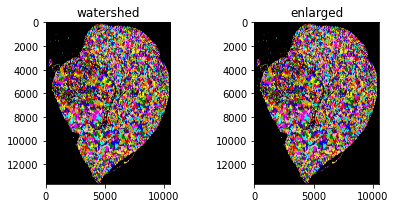

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(ssDNA_cell_labels))
axes[0].set_title('watershed')
axes[1].imshow(skimage.color.label2rgb(ssDNA_cell_labels_enlarged))
axes[1].set_title('enlarged')
np.save("ssDNA_cell_labels.npy", ssDNA_cell_labels_enlarged)
#Using 'ssDNA_cell_labels_enlarged = np.load("ssDNA_cell_labels.npy")'  to read in cell labels for following steps.